### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [17]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [18]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_benign/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_benign/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_benign/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_benign/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 261 elements
My custom valing-dataset has 88 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

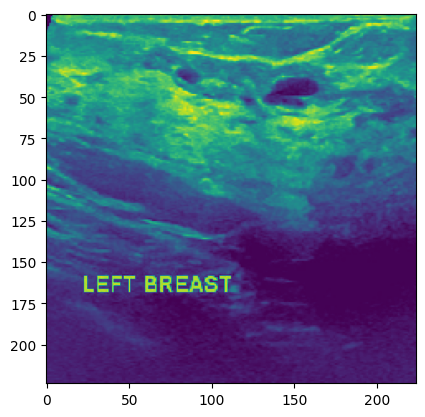

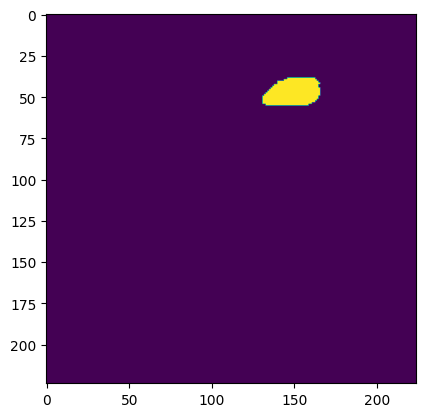

3픽셀의 평균값이라 색깔이 변경됨.


In [19]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
# Begin training
from models.pop_medical_seg_models.nnunet import Nested_UNet as UNet_2p

model = UNet_2p(1,3)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [21]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [22]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'UNet++'
data_name = 'benign'

# 5. Training

 Epoch: 1 of 100, Iter.: 33 of 33, Train Loss: 1.379261, IoU: 0.241869, Dice: 0.341613
 Epoch: 1 of 100, Iter.: 33 of 33, Valid Loss: 1.389645, IoU: 0.000000, Dice: 0.000000

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


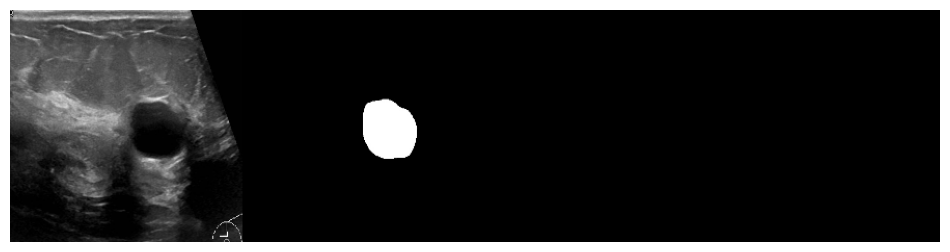

 Epoch: 2 of 100, Iter.: 33 of 33, Train Loss: 1.242479, IoU: 0.403258, Dice: 0.516793
 Epoch: 2 of 100, Iter.: 33 of 33, Valid Loss: 1.267836, IoU: 0.278736, Dice: 0.389539


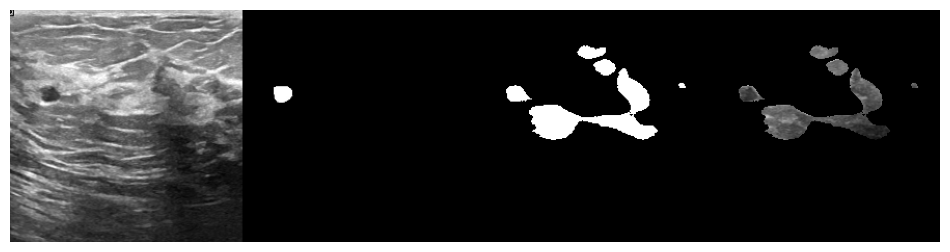

 Epoch: 3 of 100, Iter.: 33 of 33, Train Loss: 1.201815, IoU: 0.407860, Dice: 0.522881
 Epoch: 3 of 100, Iter.: 33 of 33, Valid Loss: 1.177153, IoU: 0.383279, Dice: 0.490332


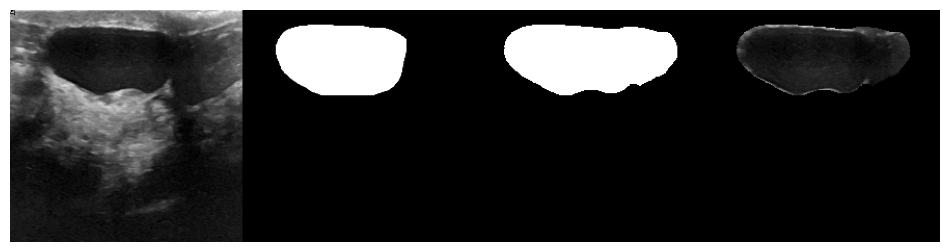

 Epoch: 4 of 100, Iter.: 33 of 33, Train Loss: 1.157894, IoU: 0.454751, Dice: 0.567046
 Epoch: 4 of 100, Iter.: 33 of 33, Valid Loss: 1.163738, IoU: 0.457716, Dice: 0.565250


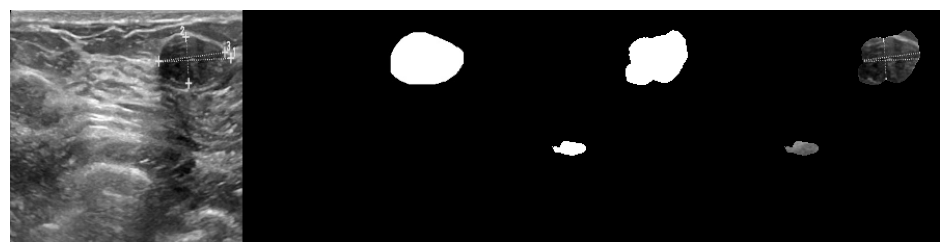

 Epoch: 5 of 100, Iter.: 33 of 33, Train Loss: 1.127592, IoU: 0.495742, Dice: 0.608001
 Epoch: 5 of 100, Iter.: 33 of 33, Valid Loss: 1.132256, IoU: 0.452867, Dice: 0.561285


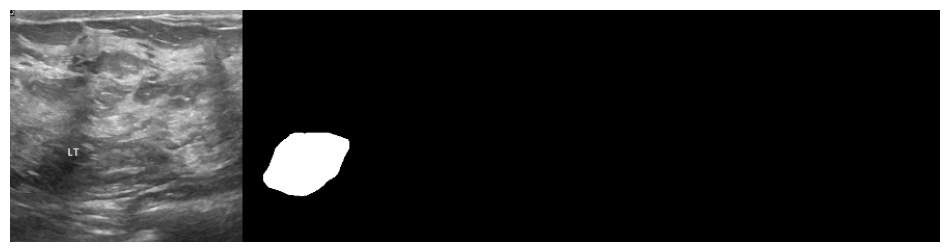

 Epoch: 6 of 100, Iter.: 33 of 33, Train Loss: 1.101267, IoU: 0.514796, Dice: 0.626640
 Epoch: 6 of 100, Iter.: 33 of 33, Valid Loss: 1.178816, IoU: 0.346956, Dice: 0.456833


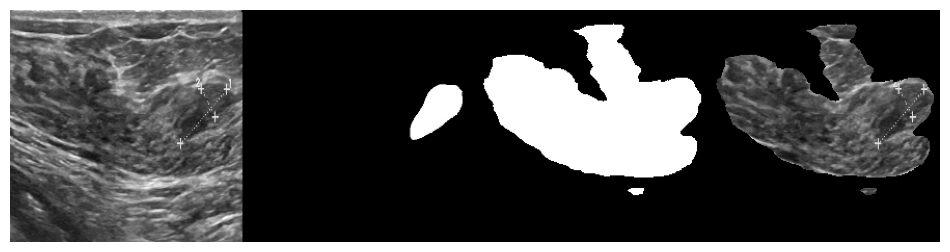

 Epoch: 7 of 100, Iter.: 33 of 33, Train Loss: 1.081863, IoU: 0.511296, Dice: 0.623535
 Epoch: 7 of 100, Iter.: 33 of 33, Valid Loss: 1.126426, IoU: 0.424745, Dice: 0.538537


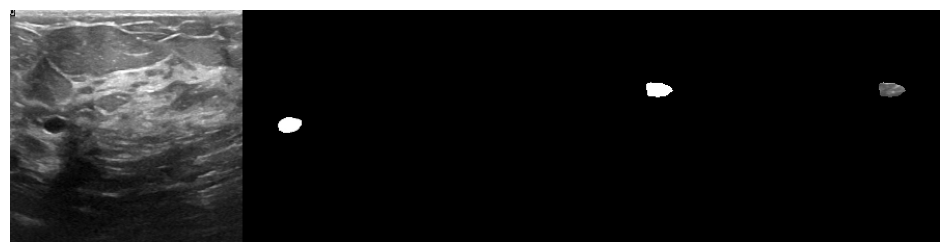

 Epoch: 8 of 100, Iter.: 33 of 33, Train Loss: 1.054266, IoU: 0.557975, Dice: 0.668862
 Epoch: 8 of 100, Iter.: 33 of 33, Valid Loss: 1.048681, IoU: 0.518625, Dice: 0.616999


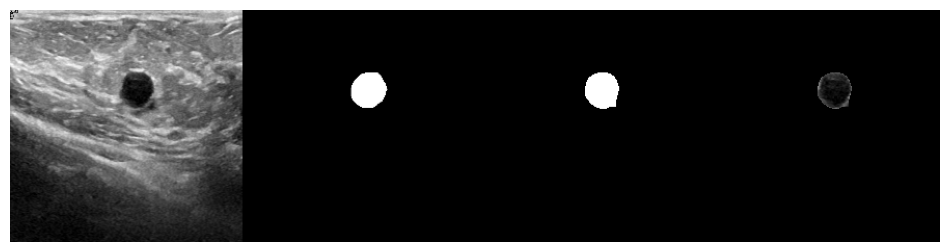

 Epoch: 9 of 100, Iter.: 33 of 33, Train Loss: 1.034615, IoU: 0.558692, Dice: 0.670253
 Epoch: 9 of 100, Iter.: 33 of 33, Valid Loss: 1.036543, IoU: 0.529796, Dice: 0.621187


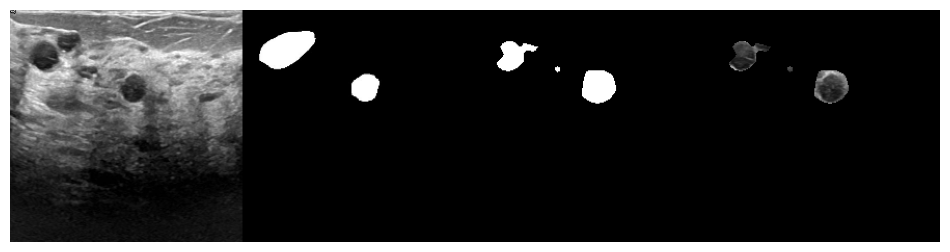

 Epoch: 10 of 100, Iter.: 33 of 33, Train Loss: 1.008143, IoU: 0.564620, Dice: 0.676547
 Epoch: 10 of 100, Iter.: 33 of 33, Valid Loss: 1.028130, IoU: 0.525958, Dice: 0.623771


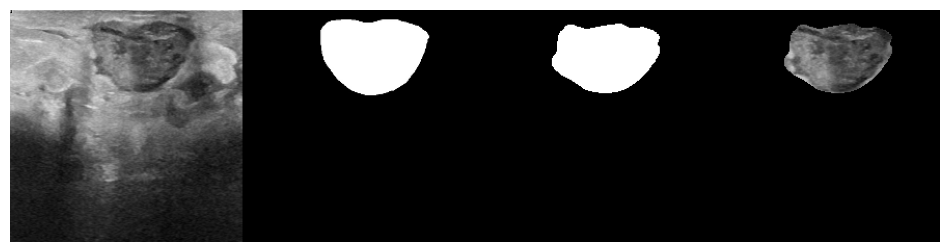

 Epoch: 11 of 100, Iter.: 33 of 33, Train Loss: 0.997692, IoU: 0.580646, Dice: 0.689884
 Epoch: 11 of 100, Iter.: 33 of 33, Valid Loss: 1.122081, IoU: 0.372371, Dice: 0.472621


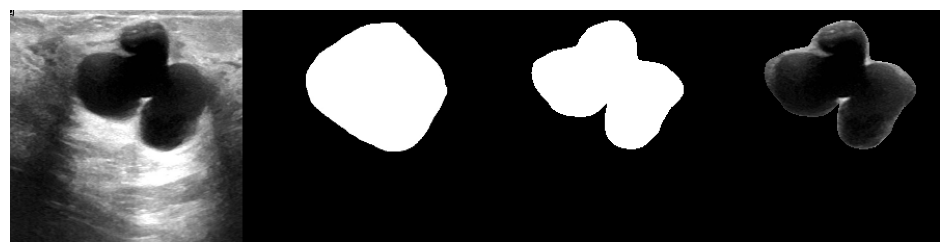

 Epoch: 12 of 100, Iter.: 33 of 33, Train Loss: 0.961440, IoU: 0.623337, Dice: 0.732513
 Epoch: 12 of 100, Iter.: 33 of 33, Valid Loss: 1.084439, IoU: 0.361839, Dice: 0.463618


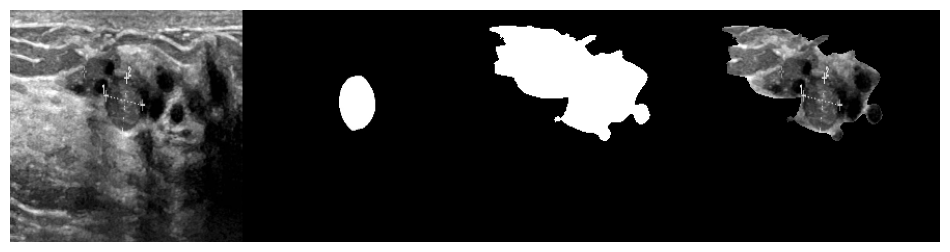

 Epoch: 13 of 100, Iter.: 33 of 33, Train Loss: 0.926135, IoU: 0.679881, Dice: 0.779633
 Epoch: 13 of 100, Iter.: 33 of 33, Valid Loss: 0.993807, IoU: 0.521846, Dice: 0.628425


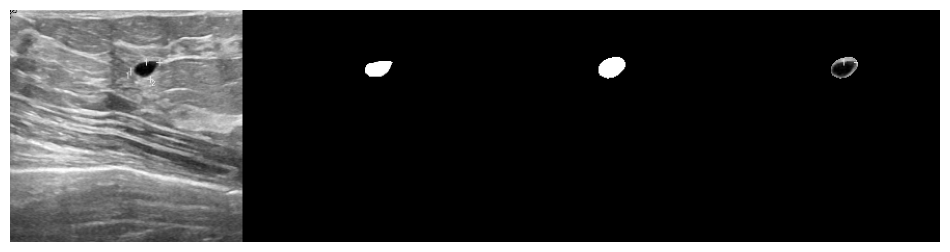

 Epoch: 14 of 100, Iter.: 33 of 33, Train Loss: 0.920626, IoU: 0.672519, Dice: 0.774312
 Epoch: 14 of 100, Iter.: 33 of 33, Valid Loss: 0.986930, IoU: 0.498514, Dice: 0.594827


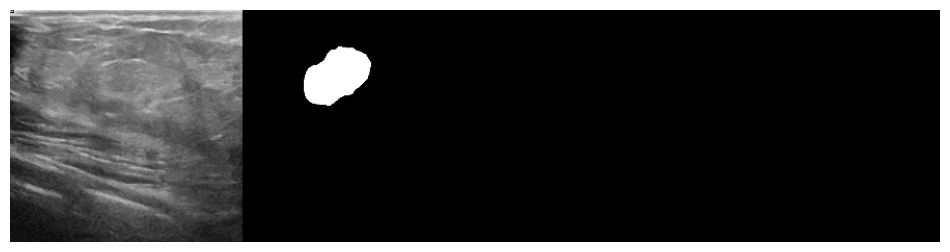

 Epoch: 15 of 100, Iter.: 33 of 33, Train Loss: 0.894339, IoU: 0.681786, Dice: 0.783582
 Epoch: 15 of 100, Iter.: 33 of 33, Valid Loss: 0.969846, IoU: 0.498217, Dice: 0.593467


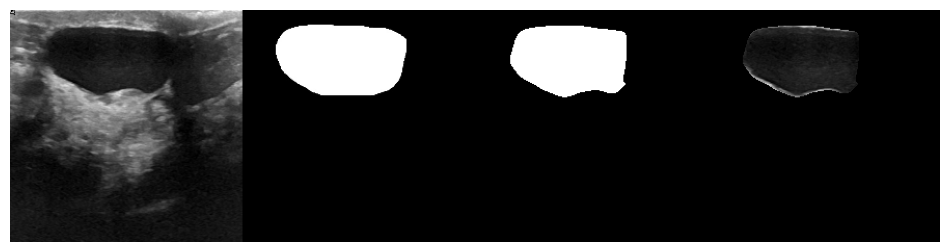

 Epoch: 16 of 100, Iter.: 33 of 33, Train Loss: 0.870037, IoU: 0.693205, Dice: 0.788773
 Epoch: 16 of 100, Iter.: 33 of 33, Valid Loss: 0.956064, IoU: 0.567007, Dice: 0.666965


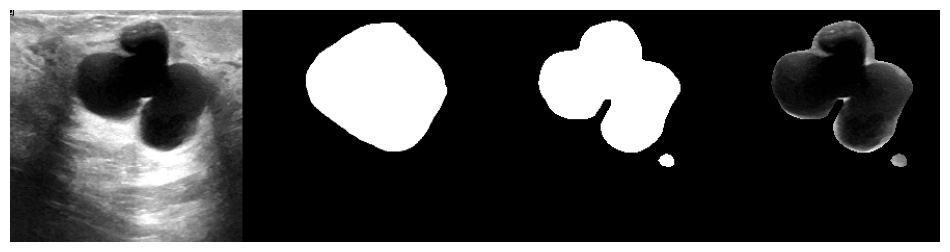

 Epoch: 17 of 100, Iter.: 33 of 33, Train Loss: 0.859402, IoU: 0.683590, Dice: 0.784943
 Epoch: 17 of 100, Iter.: 33 of 33, Valid Loss: 1.053591, IoU: 0.368041, Dice: 0.472876


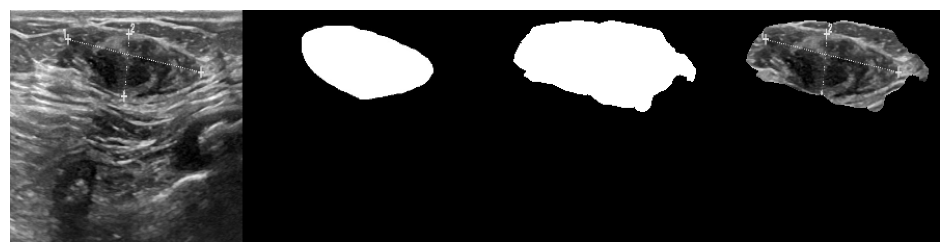

 Epoch: 18 of 100, Iter.: 33 of 33, Train Loss: 0.850834, IoU: 0.694402, Dice: 0.793569
 Epoch: 18 of 100, Iter.: 33 of 33, Valid Loss: 0.943831, IoU: 0.497948, Dice: 0.587707


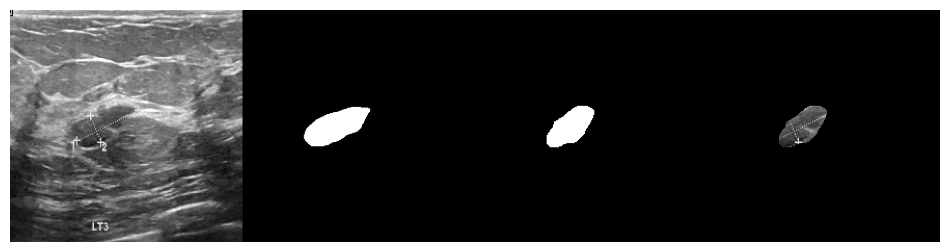

 Epoch: 19 of 100, Iter.: 33 of 33, Train Loss: 0.826925, IoU: 0.715536, Dice: 0.812332
 Epoch: 19 of 100, Iter.: 33 of 33, Valid Loss: 0.885059, IoU: 0.576354, Dice: 0.670070


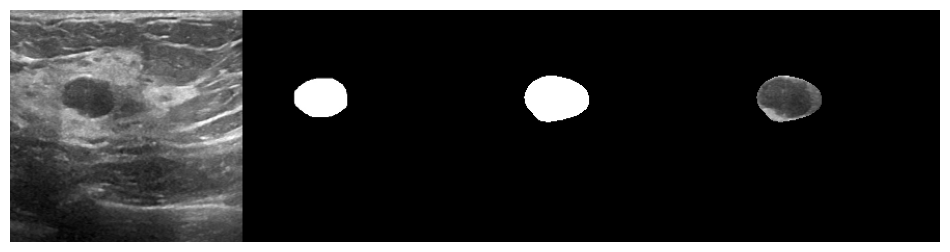

 Epoch: 20 of 100, Iter.: 33 of 33, Train Loss: 0.787410, IoU: 0.748276, Dice: 0.838126
 Epoch: 20 of 100, Iter.: 33 of 33, Valid Loss: 0.885382, IoU: 0.565804, Dice: 0.666152


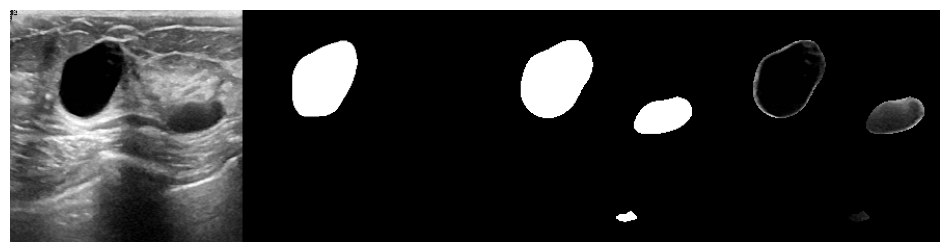

 Epoch: 21 of 100, Iter.: 33 of 33, Train Loss: 0.767803, IoU: 0.768239, Dice: 0.854076
 Epoch: 21 of 100, Iter.: 33 of 33, Valid Loss: 0.865099, IoU: 0.539735, Dice: 0.620896


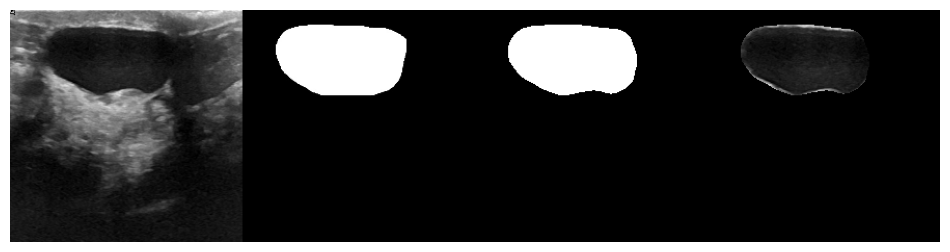

 Epoch: 22 of 100, Iter.: 33 of 33, Train Loss: 0.762153, IoU: 0.748923, Dice: 0.841210
 Epoch: 22 of 100, Iter.: 33 of 33, Valid Loss: 0.883030, IoU: 0.591093, Dice: 0.674443


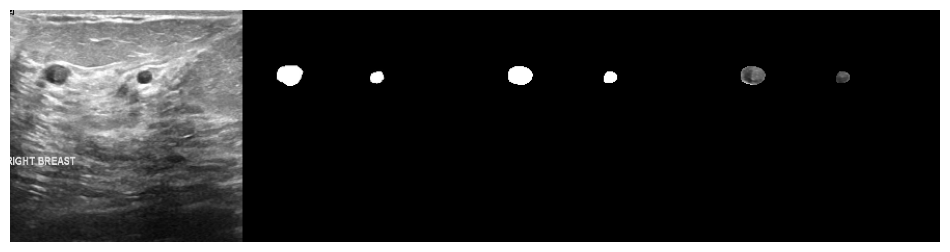

 Epoch: 23 of 100, Iter.: 33 of 33, Train Loss: 0.757408, IoU: 0.724893, Dice: 0.818681
 Epoch: 23 of 100, Iter.: 33 of 33, Valid Loss: 0.838636, IoU: 0.573117, Dice: 0.658157


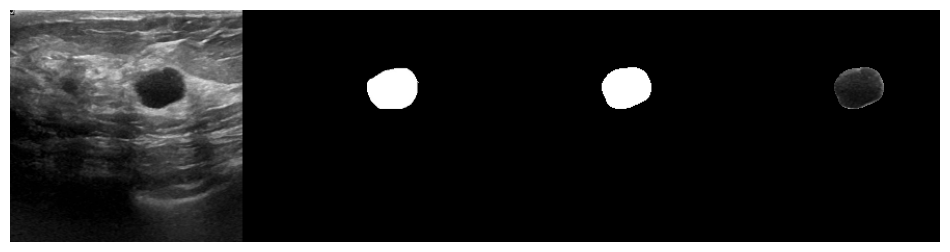

 Epoch: 24 of 100, Iter.: 33 of 33, Train Loss: 0.721618, IoU: 0.779886, Dice: 0.862136
 Epoch: 24 of 100, Iter.: 33 of 33, Valid Loss: 0.841131, IoU: 0.565151, Dice: 0.666207


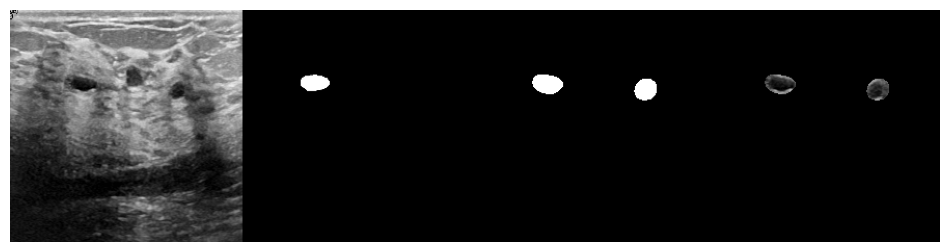

 Epoch: 25 of 100, Iter.: 33 of 33, Train Loss: 0.715649, IoU: 0.777778, Dice: 0.859353
 Epoch: 25 of 100, Iter.: 33 of 33, Valid Loss: 0.810051, IoU: 0.588401, Dice: 0.686720


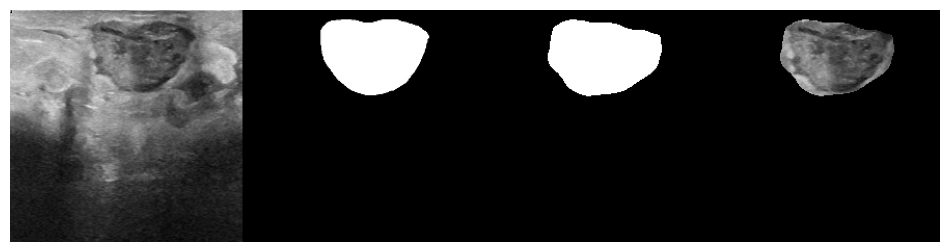

 Epoch: 26 of 100, Iter.: 33 of 33, Train Loss: 0.667524, IoU: 0.818673, Dice: 0.893113
 Epoch: 26 of 100, Iter.: 33 of 33, Valid Loss: 0.779006, IoU: 0.630211, Dice: 0.723892


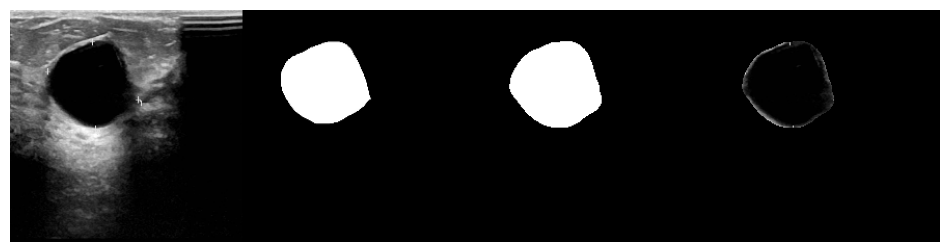

 Epoch: 27 of 100, Iter.: 33 of 33, Train Loss: 0.657464, IoU: 0.818693, Dice: 0.892155
 Epoch: 27 of 100, Iter.: 33 of 33, Valid Loss: 0.787940, IoU: 0.636265, Dice: 0.723295


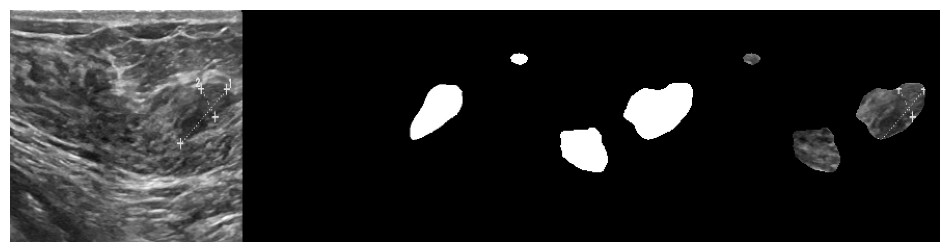

 Epoch: 28 of 100, Iter.: 33 of 33, Train Loss: 0.629001, IoU: 0.826511, Dice: 0.896882
 Epoch: 28 of 100, Iter.: 33 of 33, Valid Loss: 0.763977, IoU: 0.623817, Dice: 0.721307


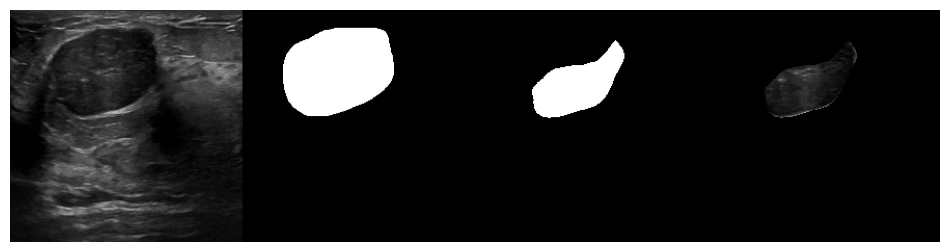

 Epoch: 29 of 100, Iter.: 33 of 33, Train Loss: 0.619085, IoU: 0.838417, Dice: 0.906681
 Epoch: 29 of 100, Iter.: 33 of 33, Valid Loss: 0.765150, IoU: 0.576358, Dice: 0.672889


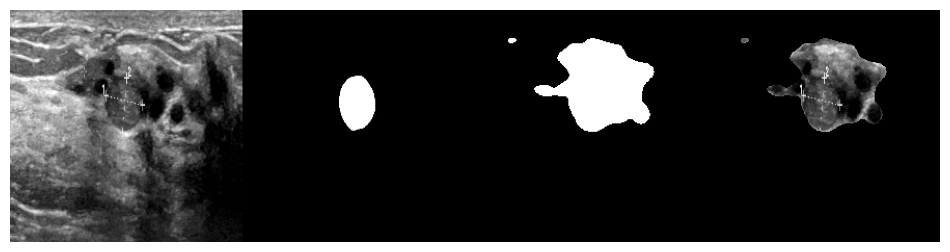

 Epoch: 30 of 100, Iter.: 33 of 33, Train Loss: 0.608736, IoU: 0.832723, Dice: 0.903722
 Epoch: 30 of 100, Iter.: 33 of 33, Valid Loss: 0.775110, IoU: 0.606354, Dice: 0.691559


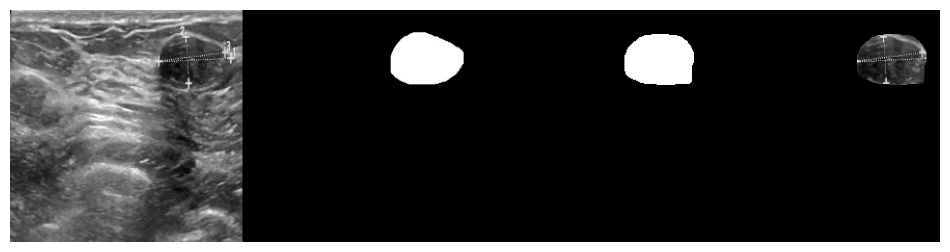

 Epoch: 31 of 100, Iter.: 33 of 33, Train Loss: 0.595196, IoU: 0.834945, Dice: 0.903934
 Epoch: 31 of 100, Iter.: 33 of 33, Valid Loss: 0.709274, IoU: 0.593244, Dice: 0.676136


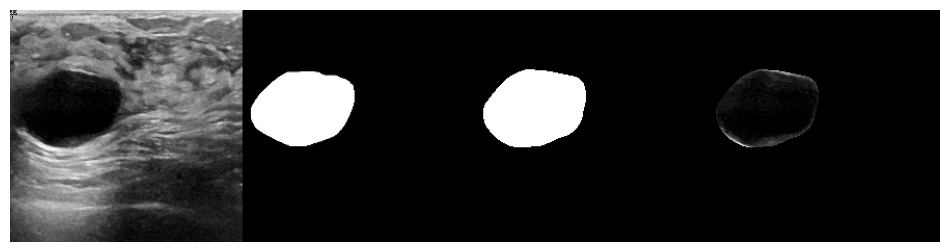

 Epoch: 32 of 100, Iter.: 33 of 33, Train Loss: 0.580884, IoU: 0.838249, Dice: 0.905479
 Epoch: 32 of 100, Iter.: 33 of 33, Valid Loss: 0.699977, IoU: 0.635325, Dice: 0.720142


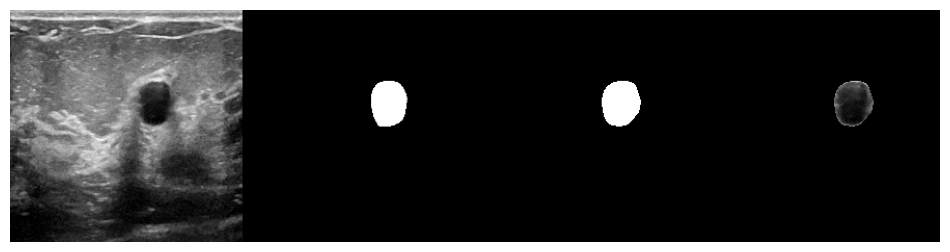

 Epoch: 33 of 100, Iter.: 33 of 33, Train Loss: 0.578572, IoU: 0.800187, Dice: 0.877057
 Epoch: 33 of 100, Iter.: 33 of 33, Valid Loss: 0.754786, IoU: 0.574659, Dice: 0.672241


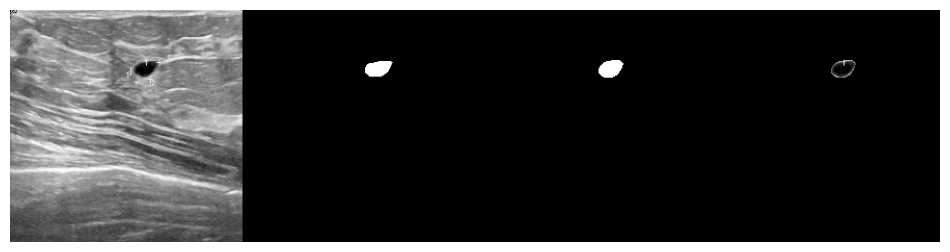

 Epoch: 34 of 100, Iter.: 33 of 33, Train Loss: 0.566493, IoU: 0.811868, Dice: 0.884526
 Epoch: 34 of 100, Iter.: 33 of 33, Valid Loss: 0.743335, IoU: 0.505858, Dice: 0.607477


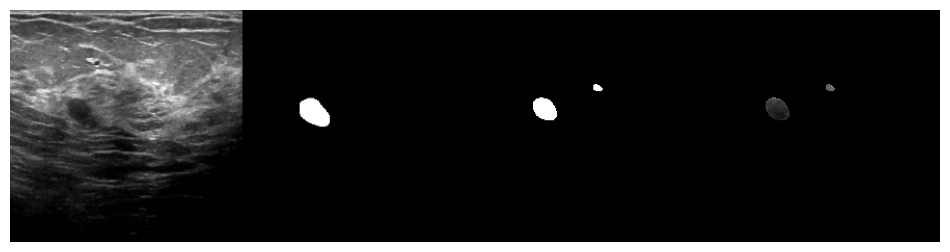

 Epoch: 35 of 100, Iter.: 33 of 33, Train Loss: 0.557473, IoU: 0.792169, Dice: 0.871380
 Epoch: 35 of 100, Iter.: 33 of 33, Valid Loss: 0.786531, IoU: 0.532053, Dice: 0.637313


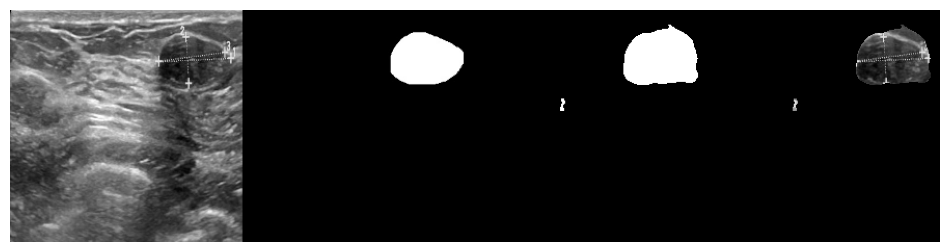

 Epoch: 36 of 100, Iter.: 33 of 33, Train Loss: 0.521051, IoU: 0.835827, Dice: 0.904354
 Epoch: 36 of 100, Iter.: 33 of 33, Valid Loss: 0.700192, IoU: 0.565660, Dice: 0.647953


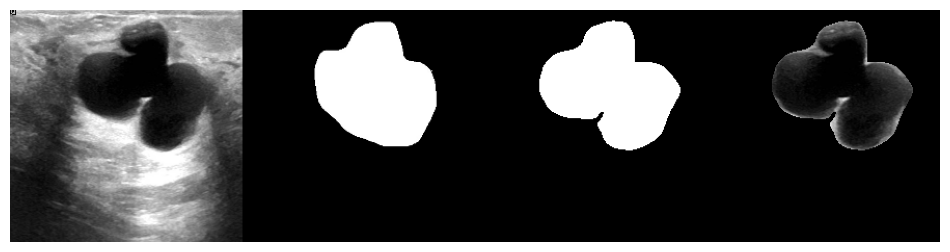

 Epoch: 37 of 100, Iter.: 33 of 33, Train Loss: 0.522385, IoU: 0.813887, Dice: 0.887950
 Epoch: 37 of 100, Iter.: 33 of 33, Valid Loss: 0.682607, IoU: 0.596134, Dice: 0.681638


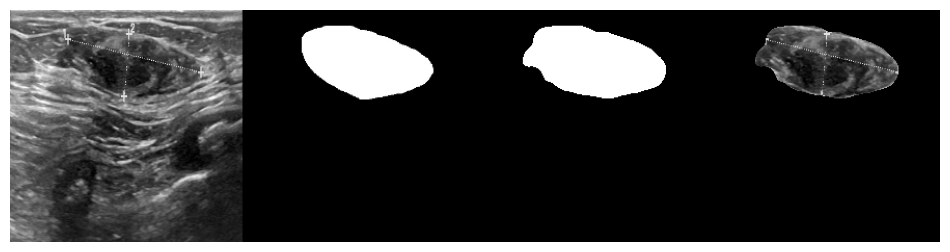

 Epoch: 38 of 100, Iter.: 33 of 33, Train Loss: 0.532015, IoU: 0.783878, Dice: 0.863000
 Epoch: 38 of 100, Iter.: 33 of 33, Valid Loss: 0.804224, IoU: 0.463380, Dice: 0.573798


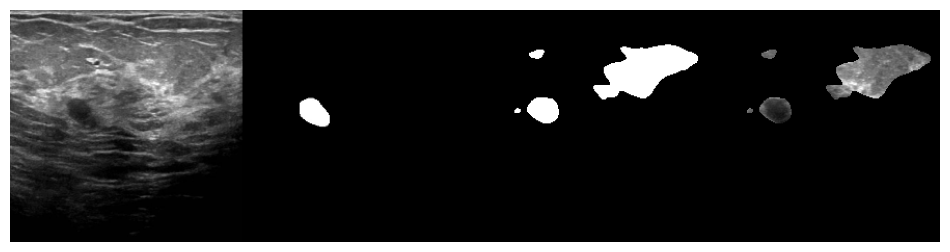

 Epoch: 39 of 100, Iter.: 33 of 33, Train Loss: 0.501500, IoU: 0.789190, Dice: 0.867125
 Epoch: 39 of 100, Iter.: 33 of 33, Valid Loss: 0.672839, IoU: 0.562903, Dice: 0.656929


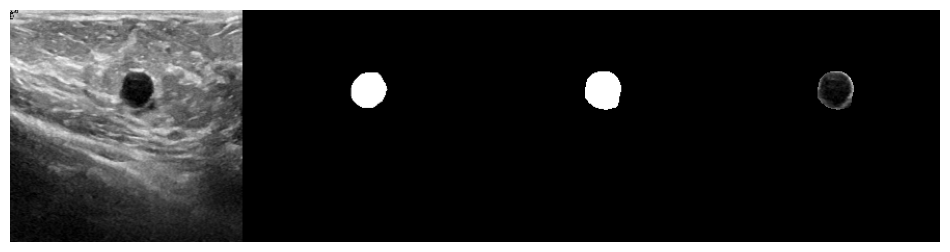

 Epoch: 40 of 100, Iter.: 33 of 33, Train Loss: 0.472443, IoU: 0.832553, Dice: 0.901093
 Epoch: 40 of 100, Iter.: 33 of 33, Valid Loss: 0.624727, IoU: 0.621744, Dice: 0.708793


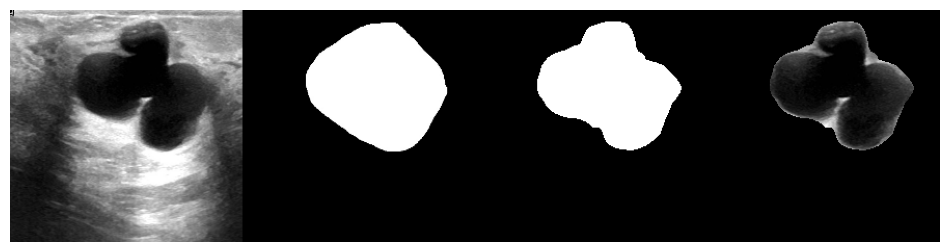

 Epoch: 41 of 100, Iter.: 33 of 33, Train Loss: 0.451407, IoU: 0.855723, Dice: 0.917360
 Epoch: 41 of 100, Iter.: 33 of 33, Valid Loss: 0.617600, IoU: 0.625287, Dice: 0.713203


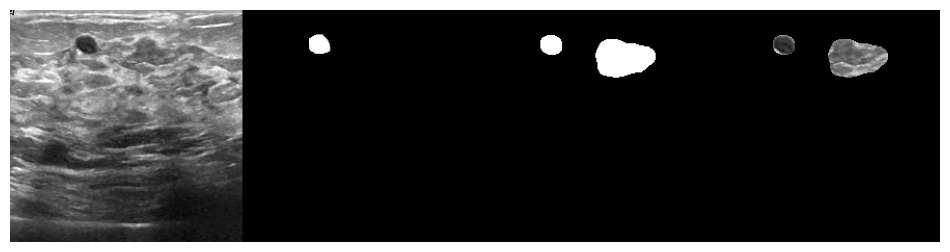

 Epoch: 42 of 100, Iter.: 33 of 33, Train Loss: 0.433684, IoU: 0.868571, Dice: 0.925997
 Epoch: 42 of 100, Iter.: 33 of 33, Valid Loss: 0.635234, IoU: 0.604832, Dice: 0.700391


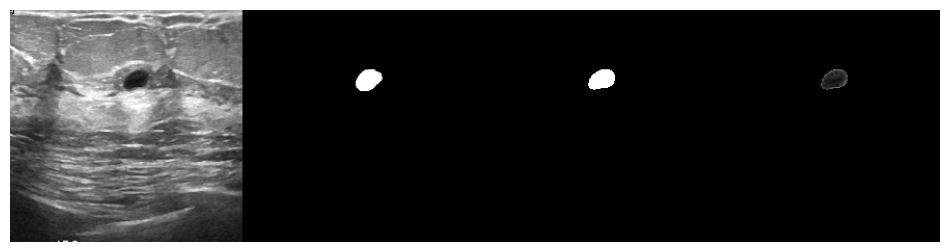

 Epoch: 43 of 100, Iter.: 33 of 33, Train Loss: 0.436880, IoU: 0.842205, Dice: 0.906602
 Epoch: 43 of 100, Iter.: 33 of 33, Valid Loss: 0.679172, IoU: 0.546178, Dice: 0.639472


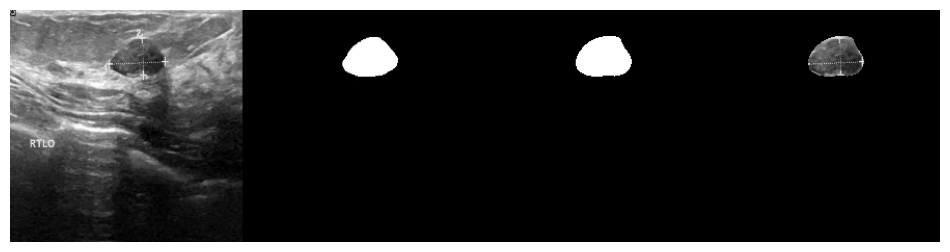

 Epoch: 44 of 100, Iter.: 33 of 33, Train Loss: 0.474573, IoU: 0.766766, Dice: 0.848221
 Epoch: 44 of 100, Iter.: 33 of 33, Valid Loss: 0.655900, IoU: 0.566443, Dice: 0.667785


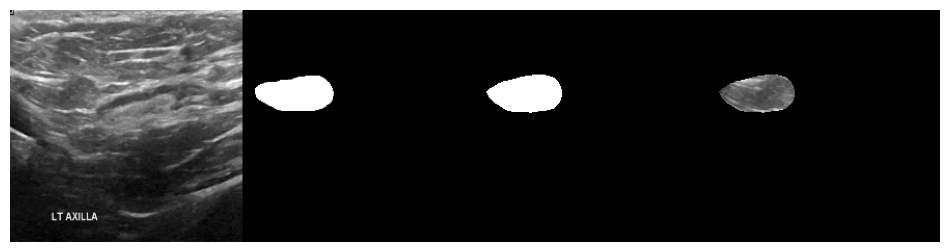

 Epoch: 45 of 100, Iter.: 33 of 33, Train Loss: 0.458924, IoU: 0.775544, Dice: 0.857218
 Epoch: 45 of 100, Iter.: 33 of 33, Valid Loss: 0.699531, IoU: 0.486176, Dice: 0.593109


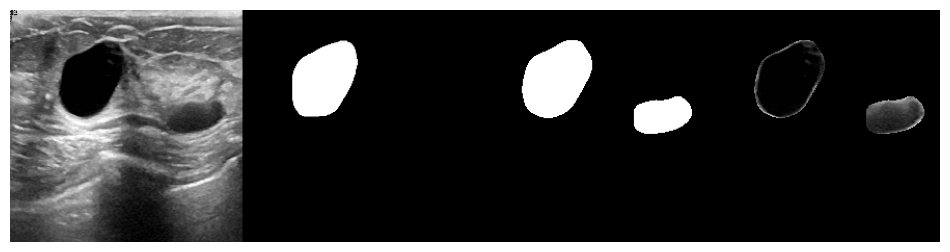

 Epoch: 46 of 100, Iter.: 33 of 33, Train Loss: 0.399208, IoU: 0.850779, Dice: 0.914474
 Epoch: 46 of 100, Iter.: 33 of 33, Valid Loss: 0.587000, IoU: 0.627938, Dice: 0.716697


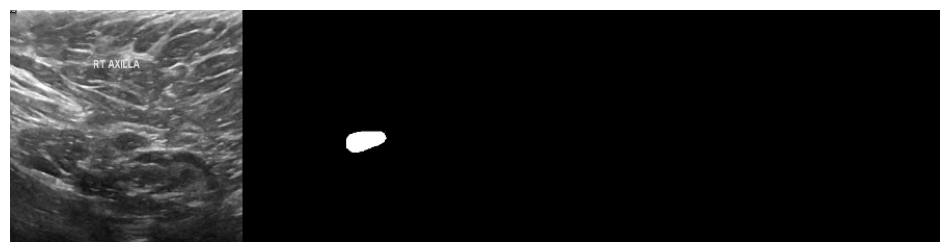

 Epoch: 47 of 100, Iter.: 33 of 33, Train Loss: 0.396141, IoU: 0.836066, Dice: 0.902774
 Epoch: 47 of 100, Iter.: 33 of 33, Valid Loss: 0.586814, IoU: 0.613888, Dice: 0.711360


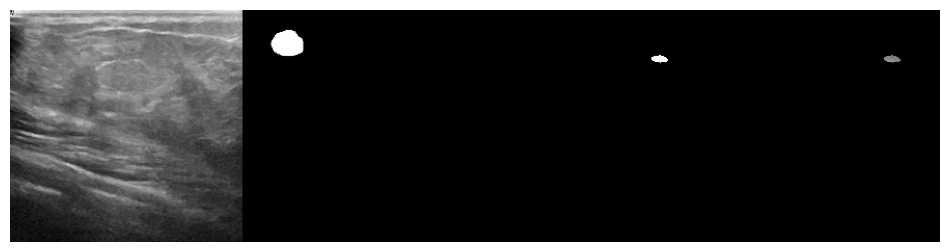


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 3min 39s, sys: 4min 21s, total: 8min
Wall time: 4min 23s


In [23]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:26, Best_IOU:0.6363, Best_DiceScore:0.7239


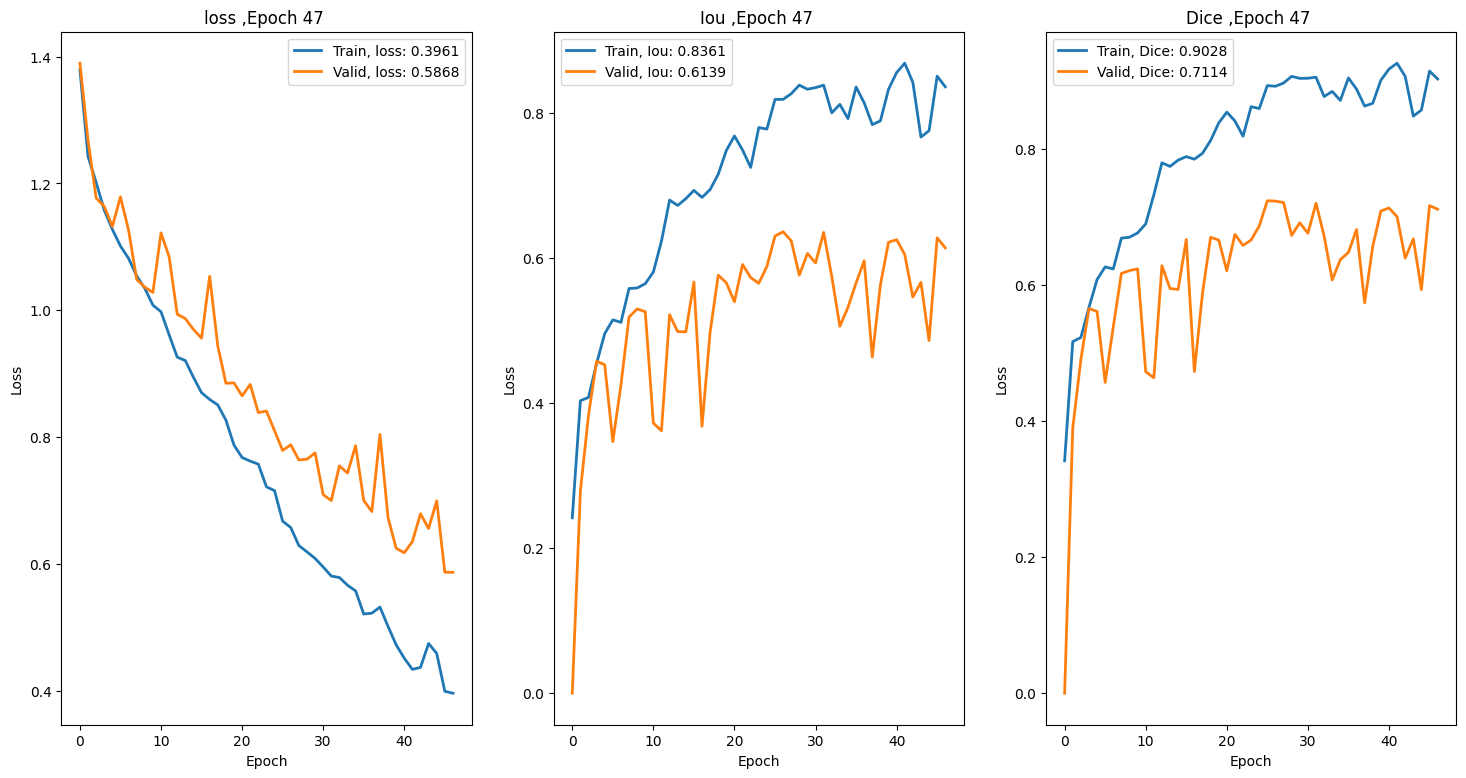

In [24]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()